# Neural style transfer

## Neural style transfer in Keras

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg"
)
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg"
)

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

943128/943128 [==============================] - 0s 0us/step


In [2]:
import numpy as np


def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img


def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [3]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

2023-02-18 22:20:29.157196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-18 22:20:29.157353: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
80134624/80134624 [==============================] - 2s 0us/step


In [4]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

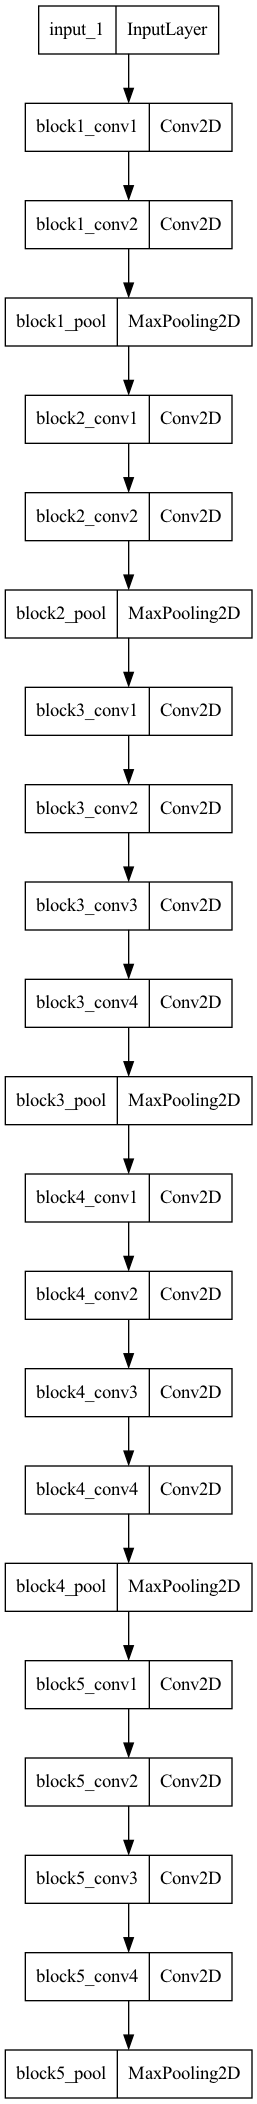

In [5]:
keras.utils.plot_model(model, "./assets/imagenet.png", show_shapes=False)

In [6]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [7]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels**2) * (size**2))

In [8]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [9]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [10]:
import tensorflow as tf


@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads


optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"./assets/combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

2023-02-18 22:22:47.290677: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-18 22:22:47.291398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Iteration 100: loss=8138.08
Iteration 200: loss=6653.08
Iteration 300: loss=6063.16
Iteration 400: loss=5742.66
Iteration 500: loss=5536.25
Iteration 600: loss=5390.38
Iteration 700: loss=5281.03
Iteration 800: loss=5195.46
Iteration 900: loss=5126.28
Iteration 1000: loss=5069.20
Iteration 1100: loss=5021.19
Iteration 1200: loss=4980.45
Iteration 1300: loss=4945.20
Iteration 1400: loss=4914.38
Iteration 1500: loss=4887.30
Iteration 1600: loss=4863.28
Iteration 1700: loss=4841.80
Iteration 1800: loss=4822.55
Iteration 1900: loss=4805.21
Iteration 2000: loss=4789.48
Iteration 2100: loss=4775.08
Iteration 2200: loss=4761.94
Iteration 2300: loss=4749.92
Iteration 2400: loss=4738.81
Iteration 2500: loss=4728.58
Iteration 2600: loss=4719.12
Iteration 2700: loss=4710.35
Iteration 2800: loss=4702.19
Iteration 2900: loss=4694.62


KeyboardInterrupt: 